# ComSeg tutorial


This tutorial is orginize as follow:

##### 1)  dataset initialization
##### 2) Create a graph of RNA molecule nodes and apply graph patitioning
##### 3) In situ clustering
##### 4) final RNA-nuclei association


In [4]:
import matplotlib
#matplotlib.use('Qt5Agg')
import sys

%matplotlib inline
sys.path  
## add conda anv 
sys.path +=['', '/home/tom/anaconda3/envs/comseg_v0/lib/python38.zip', '/home/tom/anaconda3/envs/comseg_v0/lib/python3.8', '/home/tom/anaconda3/envs/comseg_v0/lib/python3.8/lib-dynload', '/home/tom/.local/lib/python3.8/site-packages', '/home/tom/anaconda3/envs/comseg_v0/lib/python3.8/site-packages', '/home/tom/Bureau/phd/simulation/ComSeg_pkg/src']


# dataset

## 1)  dataset initialization

The fisrt step is to create a comseg-dataset. This object will preprocess the spot coordinates of each images from csv file, add optional  prior knowledge and compute the co-expression correlation at the dataset scale.


 You need a folder with you spots coordiante csv file with the naling convention {image_name}.csv 
 
 You need a folder with you prior segmentation file with the naling convention {image_name}.tiff


In [5]:
import comseg
import numpy as np
import scanpy as sc
import random
import tifffile
from comseg import dataset
import importlib
importlib.reload(dataset)

<module 'comseg.dataset' from '/home/tom/Bureau/phd/simulation/ComSeg_pkg/src/comseg/dataset.py'>

In [18]:
### define the gene you want to study, you can restrict it to few genes you want to study.
selected_genes = ['Abcg1', 'Atp6v0d2', 'Cd79a', 'Cxcl15', 'Fcer1a', 'Igfbp2','Rtkn2',  'Ms4a2']
                    # 'Ccdc153','Scgb3a2', 'Scgb1a1', 'Cst3','Cdh5', 'Clec14a','Inmt', 
                   #  'Pcolce2','C1qc', 'C1qa', 'C1qb','Upk3b','Ifitm6','Plac8','Ms4a4b', 'Ccl5', 'Hcst',"Sftpc"
                    # 'Gzma', 'Ncr1','S100a9','Mmrn1', 'Acta2','Myh11', 'Cd3g', 'Cd3d', ]

selected_genes = np.unique(selected_genes)

## path to you .csv spots coordiante folder
path_dataset_folder = "/media/tom/T7/simulation/test_set/small_df"


##path to your prior segmentation mask
path_to_mask_prior = "/media/tom/T7/simulation/test_set/mask"

## scale/ pixel size in um 
dico_scale = {"x": 0.103, 'y': 0.103, "z": 0.3}


### create the dataset object 
dataset = comseg.dataset.ComSegDataset(selected_genes = selected_genes,
            path_dataset_folder = path_dataset_folder,
            path_to_mask_prior =path_to_mask_prior,
            dico_scale={"x": 0.103, 'y': 0.103, "z": 0.3},
            mask_file_extension = ".tiff",
)


### add prior knowledge, here using nucleus segmentation mask
dataset.add_prior_from_mask(prior_keys_name = 'in_nucleus',  overwrite = True)

add 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004
add 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006
add prior to 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004
add prior to 07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006


In [19]:
np.unique(dataset[1].gene)

array(['Abcg1', 'Atp6v0d2', 'Cd79a', 'Cxcl15', 'Igfbp2', 'Ms4a2'],
      dtype=object)

In [20]:
### compute the co-expression correlation at the dataset scale
dico_proba_edge, count_matrix = dataset.compute_edge_weight(  # in micrometer
        images_subset = None,
        mode="nearest_nn_radius",
        n_neighbors=25,
        radius=1,  # in micormeter
        distance="pearson",
        per_images=False,
        sampling=False,
        sampling_size=100000
        )

image name :  07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004
image name :  07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006


  0%|                                                                                                                                                                                                             | 0/8 [00:00<?, ?it/s]/home/tom/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1961.90it/s]


#### the estimated co-expression coreelation matrix between gene can be vizualised as folow
                            

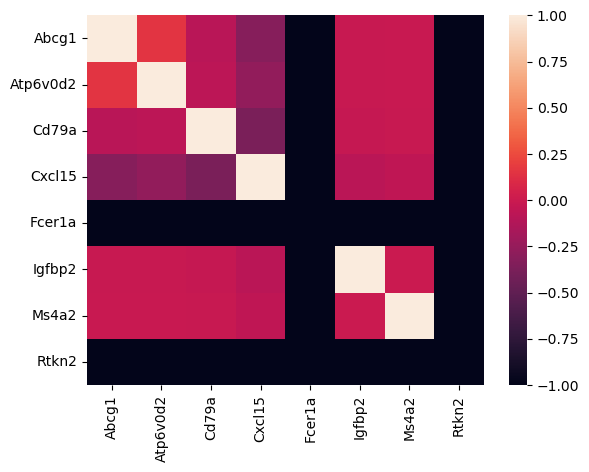

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt

corr_matrix = []

for gene0 in  dataset.dict_co_expression:
    list_corr_gene0 = []
    for gene1 in dataset.dict_co_expression:
        list_corr_gene0.append(dataset.dict_co_expression[gene0][gene1])
    corr_matrix.append(list_corr_gene0)
list_gene = list(dataset.dict_co_expression.keys())
#plotting the heatmap for correlation
ax = sns.heatmap(corr_matrix, xticklabels = list_gene, yticklabels = list_gene,)
plt.show()

## 2) Create a graph of RNA molecule nodes and apply graph patitioning

 - we will use the previously computed co-expression weight to weight a KNN of graph of RNA
 - split this graph in community 

In [22]:
## recode sc transform 

In [27]:
import comseg
from comseg import model
from comseg import dictionary
import importlib
importlib.reload(comseg)
importlib.reload(model)
importlib.reload(dictionary)

<module 'comseg.dictionary' from '/home/tom/Bureau/phd/simulation/ComSeg_pkg/src/comseg/dictionary.py'>

In [28]:

### HYPER PARAMETER TO SET
mean_cell_diameter=15  # in micrometer
max_cell_length=100  # in micrometer


Comsegdict = dictionary.ComSegDict()
for img_name  in dataset:
    
    #### GRAPH CREATION 
    comseg_m = model.ComSeg(selected_genes = dataset.selected_genes,
        df_spots_label = dataset[img_name],
                 dict_scale={"x": 0.103, 'y': 0.103, "z": 0.3},
                mean_cell_diameter=mean_cell_diameter,  # in micrometer
                max_cell_length=max_cell_length,  # in micrometer
)
    comseg_m.create_graph(dict_co_expression=dataset.dict_co_expression ,
                         )
    
    #### COMMÛTE COMMUNITY OF RNA

    comseg_m.community_vector(
                             clustering_method="louvain_with_prior",
                             weights_name="weight",

                             prior_keys="in_nucleus",
                             seed=None,
                             super_node_prior_keys="in_nucleus",
                             confidence_level=1,
                             )
    Comsegdict[img_name] = comseg_m

computing knn
adding edges
creation of  super node with in_nucleus
computing knn
adding edges
creation of  super node with in_nucleus


## 3) IN SITU CLUSTERING

In the previous step we create a graph of RNA nodes  and spits the partition this graph into community of RNA.

In this step we will extract the transcriptomic profil of all RNA partition/community and cluster them to estimate the different transciptomic profile prensent into the input tissue

In [29]:
Comsegdict.compute_insitu_clustering(
                                  size_commu_min=3,
                                  norm_vector=True,
                                  ### parameter clustering
                                  n_pcs=3,
                                  n_comps=3,
                                  clustering_method="leiden",
                                  n_neighbors=20,
                                  resolution=1,
                                  n_clusters_kmeans=4,
                                  palette=None,
                                  nb_min_cluster=0,
                                  min_merge_correlation=0.8,
                                  )

/home/tom/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


shape count matrix (420, 6)
Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Writing temporary files...
Running scTransform via Rscript...

Attaching package: arrow

The following objects are masked from package:feather:

    read_feather, write_feather

The following object is masked from package:utils:

    timestamp

Calculating cell attributes from input UMI matrix: log_umi
Variance stabilizing transformation of count matrix of size 6 by 420
Model formula is y ~ log_umi
Get Negative Binomial regression parameters per gene
Using 6 genes, 420 cells
  |======================================================================| 100%
Second step: Get residuals using fitted parameters for 6 genes
  |                                                                            ======================================================================| 100%
Calculating gene attributes
Wall clock passed: Time difference of 0.2454736 secs
Reading output files...
Clipping residuals...
number of cl

/home/tom/Bureau/phd/simulation/ComSeg_pkg/src/comseg/utils/preprocessing.py:27: RuntimeWarning: divide by zero encountered in log10
  regressor_data[:, 1] = np.log10(np.sum(array_of_vect, axis=1))
/home/tom/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


AnnData object with n_obs × n_vars = 429 × 8
    obs: 'list_coord', 'node_index', 'prior', 'index_commu', 'nb_rna', 'img_name', 'leiden', 'leiden_merged'

### PLOT IN SITU CLUSTERING
In the following plot, one dot correspong to one community of RNA.
we can indentify the different transcriptomic profile present in the image using the community expression vector

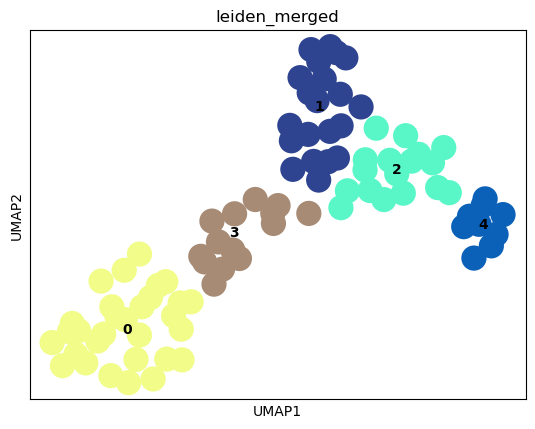

In [32]:
import scanpy as sc
import random
palette = {}
for i in range(-1, 500):
    palette[str(i)] = "#" + "%06x" % random.randint(0, 0xFFFFFF)
adata = Comsegdict.in_situ_clustering.anndata_cluster
adata.obs["leiden_merged"] = adata.obs["leiden_merged"].astype(str)
sc.tl.umap(adata)
fig_ledien = sc.pl.umap(adata, color=["leiden_merged"], palette=palette, legend_loc='on data',
                )

### Add cluster label to rna node of graphs
after this step, each node in the graph is label to by the identify  transcriptomic profile of the community it belong to.
Hence it is possible to plot a transcriptomic domain map showing not a the single cell level but at the tissue level the transcriptomic heterogenity

In [33]:
Comsegdict.add_cluster_id_to_graph(clustering_method = "leiden_merged")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3086/3086 [00:00<00:00, 354619.78it/s]


{'07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004': <comseg.model.ComSeg object at 0x7f5e87ffbe80>, '07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006': <comseg.model.ComSeg object at 0x7f5e852a9940>, 'clustering_method': 'leiden_merged', 'global_anndata': AnnData object with n_obs × n_vars = 429 × 8
    obs: 'list_coord', 'node_index', 'prior', 'index_commu', 'nb_rna', 'img_name', 'leiden', 'leiden_merged', 'in_situ_clustering': <comseg.clustering.InSituClustering object at 0x7f5e85157af0>}

###  transcriptomic domain map 

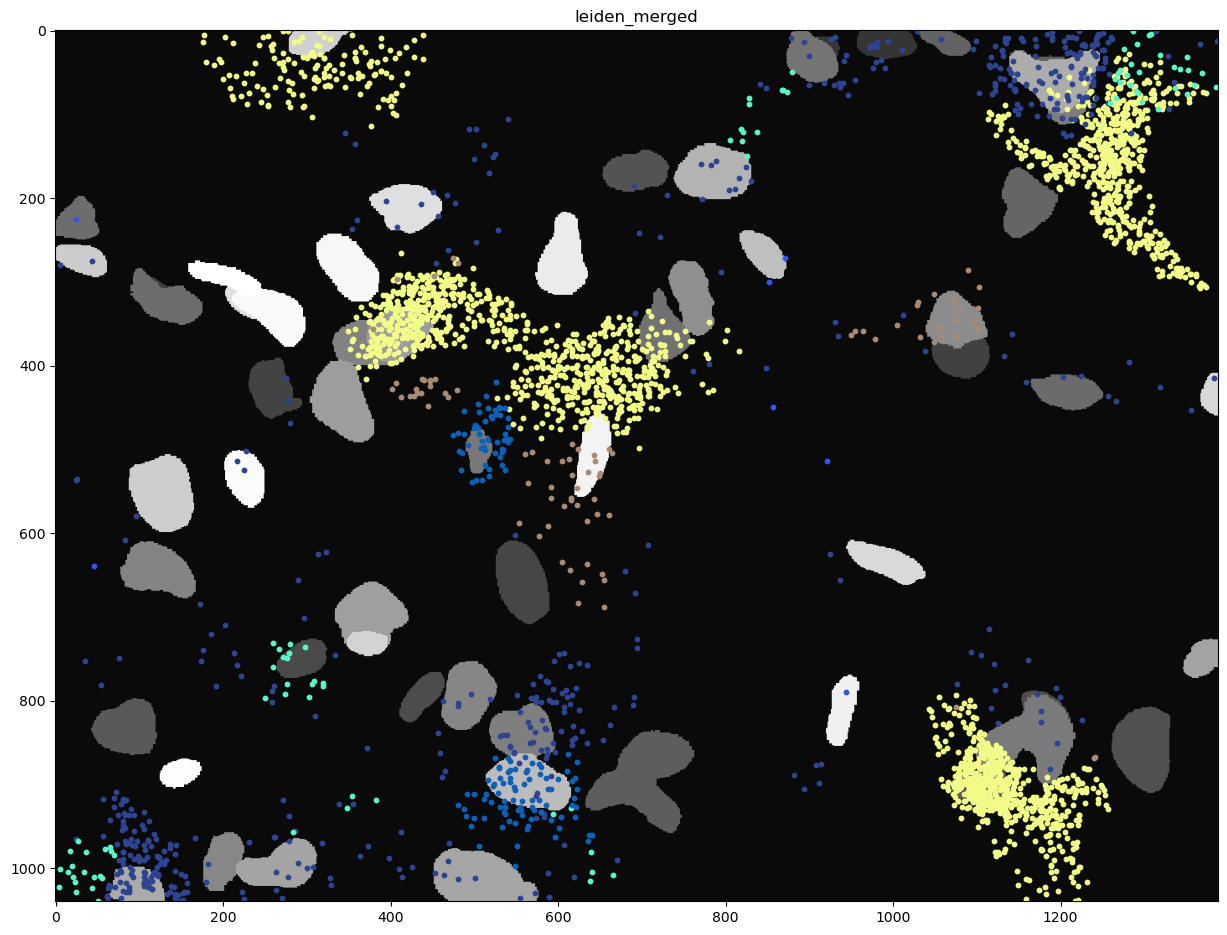

(<Figure size 1500x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'leiden_merged'}>)

In [34]:
from comseg.utils import plot
G = Comsegdict[img_name].G
nuclei = tifffile.imread(
    f'/media/tom/T7/simulation/test_set/mask/{img_name}.tiff')

plot.plot_result(G=G,
            nuclei = nuclei,
               key_node = 'leiden_merged',
                title = None,
                dico_cell_color = palette,
                figsize=(15, 15),
                spots_size = 10)


## 4) final RNA-nuclei association

### Classify nuclei centroid

We now classify each nucleus using the previously computed doamin map. each nucleus centroid is label by the most present transcriptomic profile in its neighborhood


In [35]:
Comsegdict.classify_centroid(
        path_dict_cell_centroid = "/media/tom/T7/simulation/exp_same_cyto/same_param1_4_0/remove20/dico_centroid/",
                      n_neighbors=15,
                      dict_in_pixel=True,
                      max_dist_centroid=None,
                      key_pred="leiden_merged",
                      distance="gaussian",
                      convex_hull_centroid=True,
                        file_extension = ".tiff.npy")

  0%|                                                                                                                                                                                                             | 0/5 [00:00<?, ?it/s]/home/tom/Bureau/phd/simulation/ComSeg_pkg/src/comseg/model.py:420: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_type_list = index_type_list[type_list == pred_cluster]
/home/tom/Bureau/phd/simulation/ComSeg_pkg/src/comseg/model.py:420: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_type_list = index_type_list[type_list == pred_cluster]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.67it/s]

'centroid_um'
'centroid_um'


### todo add a vizualization of the classify nuclei

### apply dikstra

We now apply the dikstra algorithm to associate nucleus centroid to the neirest RNAs labeled by the same transcriptomic cluster.

In [36]:
Comsegdict.associate_rna2landmark(
                         key_pred = "leiden_merged",
                         super_node_prior_key='in_nucleus',
                         distance='distance',
                         max_distance=100)

  0%|                                                                                                                                                                                                             | 0/5 [00:00<?, ?it/s]

max distance is 100


 20%|███████████████████████████████████████▍                                                                                                                                                             | 1/5 [00:00<00:02,  1.48it/s]

max distance is 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


### plot of final RNA-NUCLEUS assignement

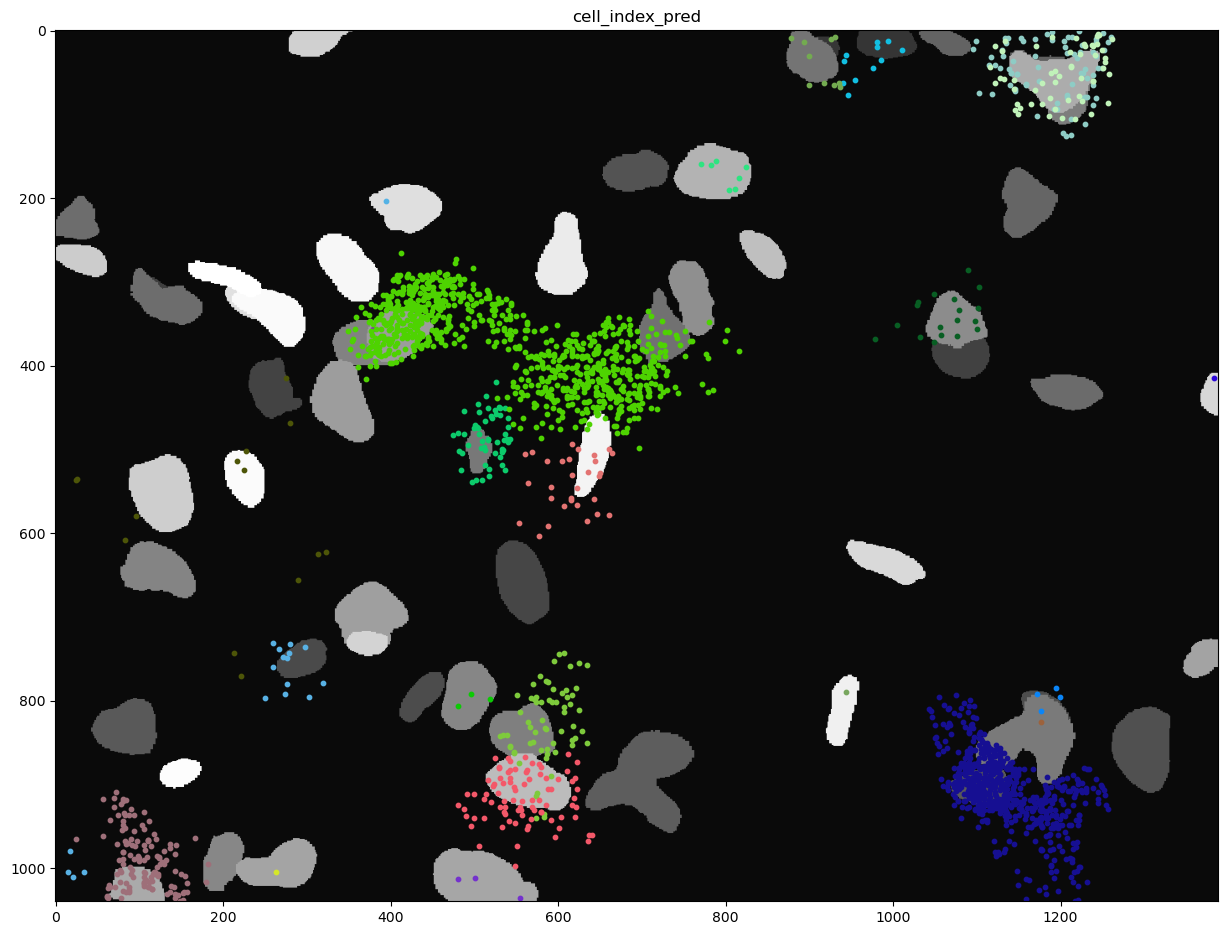

(<Figure size 1500x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'cell_index_pred'}>)

In [37]:
importlib.reload(comseg)
from comseg.utils import plot 
importlib.reload(plot)

G = Comsegdict[img_name].G
nuclei = tifffile.imread(
    f'/media/tom/T7/simulation/test_set/mask/{img_name}.tiff')

plot.plot_result(G=G,
            nuclei = nuclei,
               key_node = 'cell_index_pred',
                title = None,
                dico_cell_color = None,
                figsize=(15, 15),
                spots_size = 10,
                plot_outlier = False)


### OUTPUT ANNDATA

the final output of this pipeline is an AnnData object so our model can be integrated into Scanpy/Scverse single cell workflow analysis. 
it contain for each cell an exppression vector, thee cell centoir coordinalt and the molecule coordinate associated to this cell.

In [38]:
Comsegdict.anndata_from_comseg_result()

  0%|                                                                                                                                                                                                             | 0/5 [00:00<?, ?it/s]/home/tom/Bureau/phd/simulation/ComSeg_pkg/src/comseg/model.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  anndata.obs["spots_coordinates"] = np.array(list_cell_genes_coordinate)
/home/tom/Bureau/phd/simulation/ComSeg_pkg/src/comseg/model.py:665: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  anndata.obs["genes"] = n

### final single cell clustering from the anndata

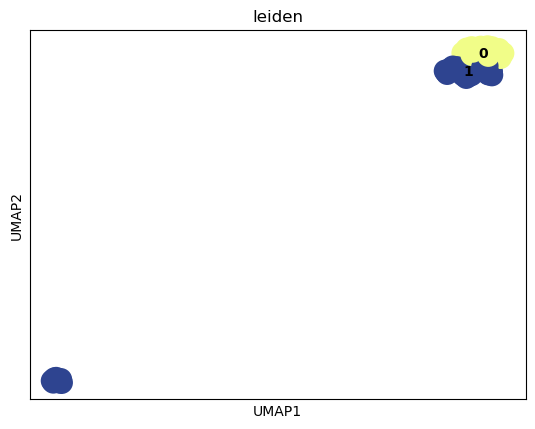

In [39]:

adata = Comsegdict.final_anndata
#sc.tl.pca(adata, svd_solver='arpack', n_comps = 0)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=0)
sc.tl.leiden(adata,  resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"], palette=palette, legend_loc='on data')
